<a href="https://colab.research.google.com/github/sirbob12/Analyst_Portfolio/blob/main/Volatility_index_price_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Volatility_100 price prediction Model
### This model is designed to predict the price actions of volatitlity_100 index using the deriv API
### Using deep learning models.such as RNN ___LSTM

In [1]:
## Lets install ta
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=28c3d4d0788923faa3d8ca3f97de1627782051109621e9265ae1e7b93ad7197f
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [2]:
#### Lets import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ta #library for forex indicators

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [3]:
!pip install requests

### First we need to create the data pipelines to get our volatility_100 data from derive using the deriv API

In [4]:
### Lets load the data with pandas
df = pd.read_csv("volatility_100.csv", header=None)  # Load without headers
df = df[0].str.split(expand=True)  # Split columns based on spaces/tabs
df.head()

,0,1,2,3,4,5,6,7,8
0,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
1,2025.01.01,00:00:00,1566.17,1583.87,1561.45,1583.66,1782,0,45
2,2025.01.01,01:00:00,1583.78,1591.93,1575.65,1584.02,1780,0,45
3,2025.01.01,02:00:00,1584.37,1625.13,1582.11,1622.73,1783,0,45
4,2025.01.01,03:00:00,1622.95,1626.23,1608.95,1609.35,1781,0,45


## Data preprocessing
### The data is not properly formatted into columns/features...
### So lets use pandas to formatt properly

In [5]:
### Lets make the header the feature names which are occupying the first row
df.columns = df.iloc[0]
df = df[1:]
df.head()


,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
1,2025.01.01,00:00:00,1566.17,1583.87,1561.45,1583.66,1782,0,45
2,2025.01.01,01:00:00,1583.78,1591.93,1575.65,1584.02,1780,0,45
3,2025.01.01,02:00:00,1584.37,1625.13,1582.11,1622.73,1783,0,45
4,2025.01.01,03:00:00,1622.95,1626.23,1608.95,1609.35,1781,0,45
5,2025.01.01,04:00:00,1609.56,1623.25,1604.68,1614.50,1785,0,45


In [6]:
df['<TIME>'].isnull().sum()

0

In [7]:
len(df['<TIME>'])

732

#### Lets get information from the data and clean the data

In [8]:
### Lets get info from the datset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 1 to 732
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   <DATE>     732 non-null    object
 1   <TIME>     732 non-null    object
 2   <OPEN>     732 non-null    object
 3   <HIGH>     732 non-null    object
 4   <LOW>      732 non-null    object
 5   <CLOSE>    732 non-null    object
 6   <TICKVOL>  732 non-null    object
 7   <VOL>      732 non-null    object
 8   <SPREAD>   732 non-null    object
dtypes: object(9)
memory usage: 51.6+ KB


In [9]:
### As you can see all the features are strings...hence we need to convert to the appropriate datatypes
### lets start with the date
df['<DATE>'] = pd.to_datetime(df['<DATE>'])
df['<DATE>'].dtype

<ipython-input-9-d6c92cb10791>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['<DATE>'] = pd.to_datetime(df['<DATE>'])


dtype('<M8[ns]')

In [10]:
### Lets deal with the time as well
df['<TIME>'] = str(df['<TIME>'])
df['<TIME>'].dtype

<ipython-input-10-64322af9d24d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['<TIME>'] = str(df['<TIME>'])


dtype('O')

In [11]:
### Lets remove the irrelevan columns from the dataset
df.columns

Index(['<DATE>', '<TIME>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>',
       '<VOL>', '<SPREAD>'],
      dtype='object', name=0)

In [12]:
df.drop('<TIME>' , axis=1, inplace=True)
df

<ipython-input-12-ea1d162e023f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('<TIME>' , axis=1, inplace=True)


,<DATE>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>,<SPREAD>
1,2025-01-01,1566.17,1583.87,1561.45,1583.66,1782,0,45
2,2025-01-01,1583.78,1591.93,1575.65,1584.02,1780,0,45
3,2025-01-01,1584.37,1625.13,1582.11,1622.73,1783,0,45
4,2025-01-01,1622.95,1626.23,1608.95,1609.35,1781,0,45
5,2025-01-01,1609.56,1623.25,1604.68,1614.50,1785,0,45
...,...,...,...,...,...,...,...,...
728,2025-01-31,1743.90,1755.85,1729.28,1739.02,1783,0,62
729,2025-01-31,1739.39,1758.71,1728.24,1758.01,1775,0,62
730,2025-01-31,1758.10,1774.31,1754.53,1767.02,1783,0,62
731,2025-01-31,1767.47,1815.64,1766.77,1808.19,1782,0,62


In [13]:
### lETS CONVERT ALL COLUMNS TO FLOAT DATATYPE APART FROM DATE
df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<VOL>']] = df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<VOL>']].astype(float)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 1 to 732
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   <DATE>     732 non-null    datetime64[ns]
 1   <OPEN>     732 non-null    float64       
 2   <HIGH>     732 non-null    float64       
 3   <LOW>      732 non-null    float64       
 4   <CLOSE>    732 non-null    float64       
 5   <TICKVOL>  732 non-null    object        
 6   <VOL>      732 non-null    float64       
 7   <SPREAD>   732 non-null    object        
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 45.9+ KB


In [15]:
df.drop('<SPREAD>', axis=1, inplace=True)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 1 to 732
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   <DATE>     732 non-null    datetime64[ns]
 1   <OPEN>     732 non-null    float64       
 2   <HIGH>     732 non-null    float64       
 3   <LOW>      732 non-null    float64       
 4   <CLOSE>    732 non-null    float64       
 5   <TICKVOL>  732 non-null    object        
 6   <VOL>      732 non-null    float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 40.2+ KB


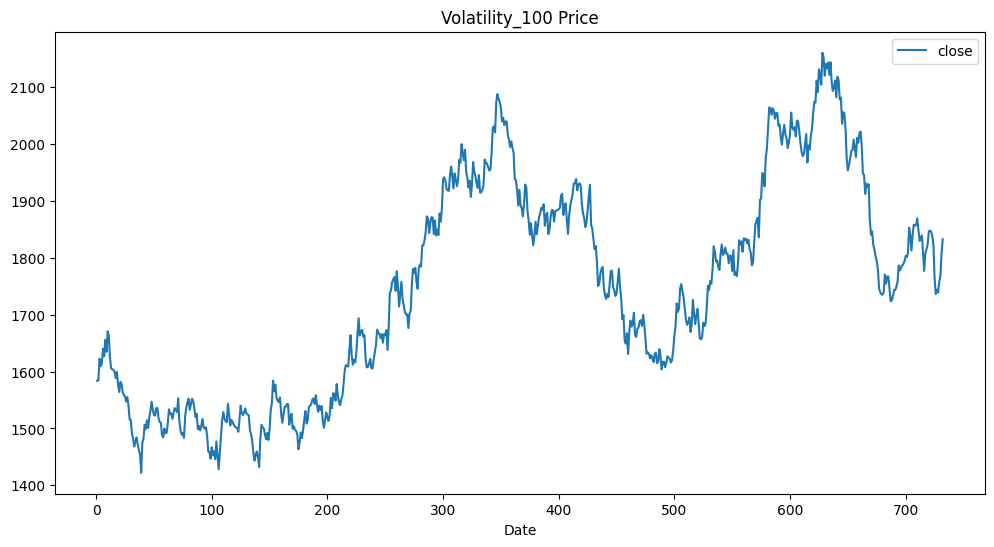

In [17]:
### Lets carry out some visualization
plt.figure(figsize=(12, 6))
plt.plot(df['<CLOSE>'], label='close')
plt.title('Volatility_100 Price')
plt.legend()
plt.xlabel('Date')
plt.show()

In [18]:
df.head()

,<DATE>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<TICKVOL>,<VOL>
1,2025-01-01,1566.17,1583.87,1561.45,1583.66,1782,0.0
2,2025-01-01,1583.78,1591.93,1575.65,1584.02,1780,0.0
3,2025-01-01,1584.37,1625.13,1582.11,1622.73,1783,0.0
4,2025-01-01,1622.95,1626.23,1608.95,1609.35,1781,0.0
5,2025-01-01,1609.56,1623.25,1604.68,1614.50,1785,0.0


In [19]:
df.drop(columns = ['<TICKVOL>', '<VOL>'], axis=1, inplace=True)
df.head()

,<DATE>,<OPEN>,<HIGH>,<LOW>,<CLOSE>
1,2025-01-01,1566.17,1583.87,1561.45,1583.66
2,2025-01-01,1583.78,1591.93,1575.65,1584.02
3,2025-01-01,1584.37,1625.13,1582.11,1622.73
4,2025-01-01,1622.95,1626.23,1608.95,1609.35
5,2025-01-01,1609.56,1623.25,1604.68,1614.50


In [20]:
### Lets create a function to use the ta library to add technical indicators to the dataset
### Lets add the moving averages and rsi indicators

def add_technical_indicators(df):

  """
   This function will add the necessary indicators to the dataset
  """
  ## Moving averages
  df['MA_10'] = ta.trend.SMAIndicator(df['<CLOSE>'], window = 10).sma_indicator()
  df['MA_20'] = ta.trend.SMAIndicator(df['<CLOSE>'], window = 20).sma_indicator()

  ## Exponential moving averages
  df['EMA_10'] = ta.trend.EMAIndicator(df['<CLOSE>'],window =10).ema_indicator()
  df['EMA_20'] = ta.trend.EMAIndicator(df['<CLOSE>'],window =20).ema_indicator()


  ## Relative Strength Index (RSI)
  df['RSI'] = ta.momentum.RSIIndicator(df['<CLOSE>'], window= 14).rsi()


  return df



In [21]:
len(df)

732

In [22]:
### Lets call the add indicators function
df = add_technical_indicators(df)

In [23]:
df.head()

,<DATE>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,MA_10,MA_20,EMA_10,EMA_20,RSI
1,2025-01-01,1566.17,1583.87,1561.45,1583.66,NaN,NaN,NaN,NaN,NaN
2,2025-01-01,1583.78,1591.93,1575.65,1584.02,NaN,NaN,NaN,NaN,NaN
3,2025-01-01,1584.37,1625.13,1582.11,1622.73,NaN,NaN,NaN,NaN,NaN
4,2025-01-01,1622.95,1626.23,1608.95,1609.35,NaN,NaN,NaN,NaN,NaN
5,2025-01-01,1609.56,1623.25,1604.68,1614.50,NaN,NaN,NaN,NaN,NaN


In [24]:
df.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'MA_10', 'MA_20', 'EMA_10', 'EMA_20', 'RSI']
df.head()

,Date,Open,High,Low,Close,MA_10,MA_20,EMA_10,EMA_20,RSI
1,2025-01-01,1566.17,1583.87,1561.45,1583.66,NaN,NaN,NaN,NaN,NaN
2,2025-01-01,1583.78,1591.93,1575.65,1584.02,NaN,NaN,NaN,NaN,NaN
3,2025-01-01,1584.37,1625.13,1582.11,1622.73,NaN,NaN,NaN,NaN,NaN
4,2025-01-01,1622.95,1626.23,1608.95,1609.35,NaN,NaN,NaN,NaN,NaN
5,2025-01-01,1609.56,1623.25,1604.68,1614.50,NaN,NaN,NaN,NaN,NaN


In [25]:
### lets drop all the nan rows
df = df.dropna()
df.head()

,Date,Open,High,Low,Close,MA_10,MA_20,EMA_10,EMA_20,RSI
20,2025-01-01,1577.93,1579.28,1555.95,1563.99,1602.995,1613.6340,1596.387903,1602.934725,37.190541
21,2025-01-01,1563.90,1588.39,1562.16,1581.72,1594.842,1613.5370,1593.721012,1600.914275,43.785165
22,2025-01-01,1581.76,1590.90,1571.06,1578.87,1590.247,1613.2795,1591.020828,1598.814820,43.003555
23,2025-01-01,1578.75,1591.84,1559.58,1563.33,1586.008,1610.3095,1585.986132,1595.435314,38.923501
24,2025-01-01,1562.68,1572.41,1557.09,1558.78,1581.511,1607.7810,1581.039562,1591.944331,37.792881


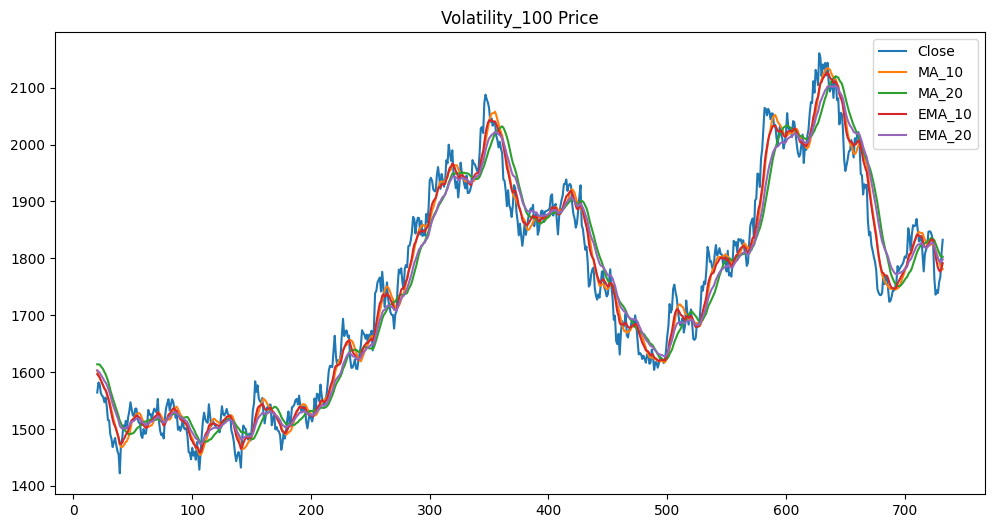

In [26]:
## lets visualize the data
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close')
plt.plot(df['MA_10'], label='MA_10')
plt.plot(df['MA_20'], label='MA_20')
plt.plot(df['EMA_10'], label='EMA_10')
plt.plot(df['EMA_20'], label='EMA_20')
plt.legend()
plt.title('Volatility_100 Price')
plt.show()

In [27]:
### lets create a function to check the distributions of the features
def create_histograms(feature):
  """
  This function will create a histogram for each feature in the dataset
  """
  plt.hist(df[feature], bins=30, alpha=0.5, label='Open')
  plt.title(f'Distribution of {feature}')
  plt.xlabel(feature)
  plt.ylabel('Frequency')
  plt.legend()
  plt.show()

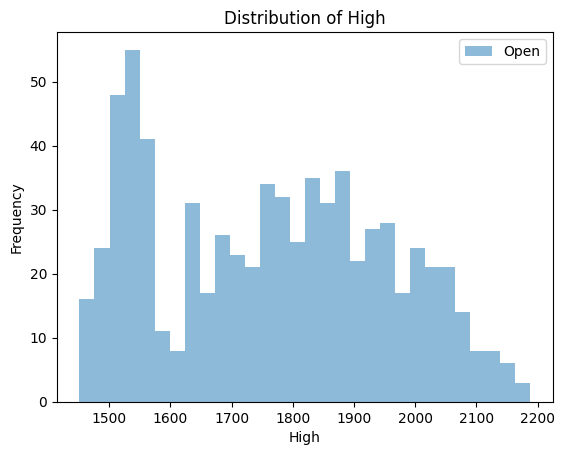

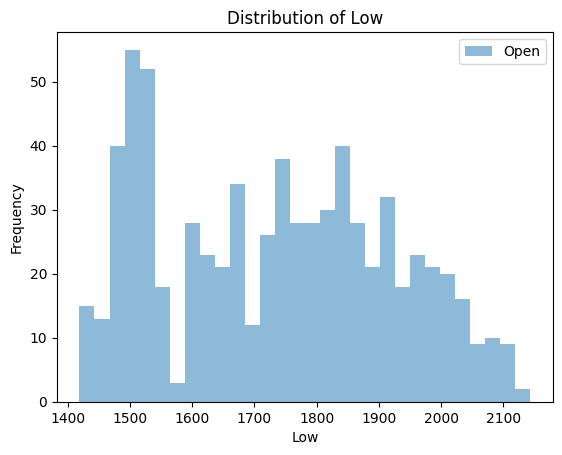

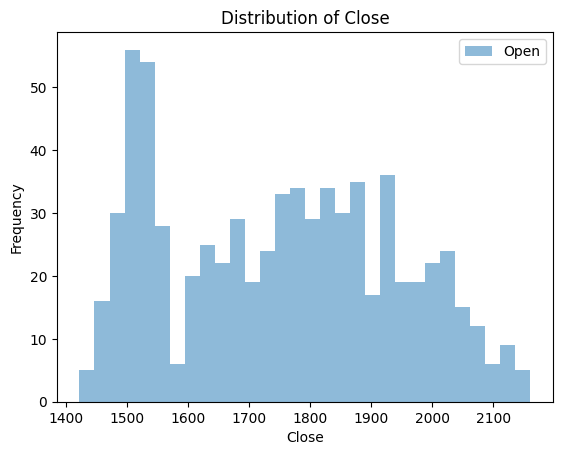

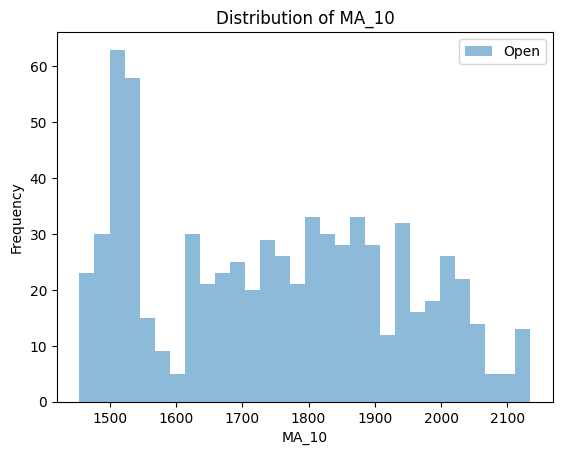

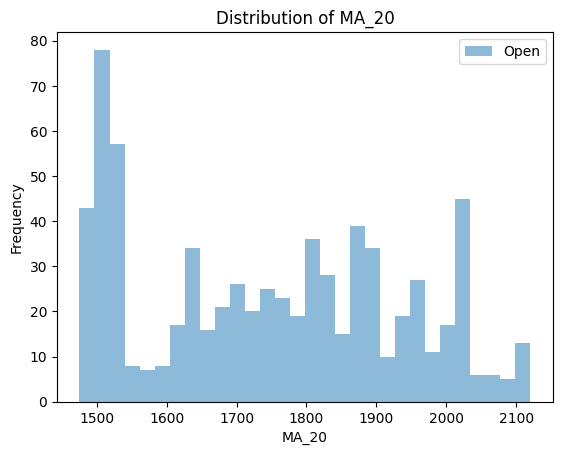

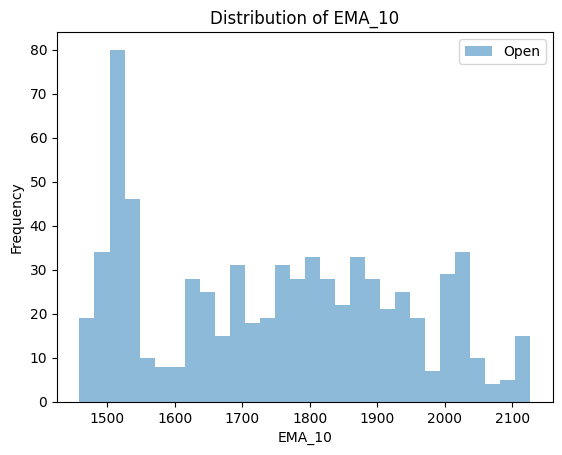

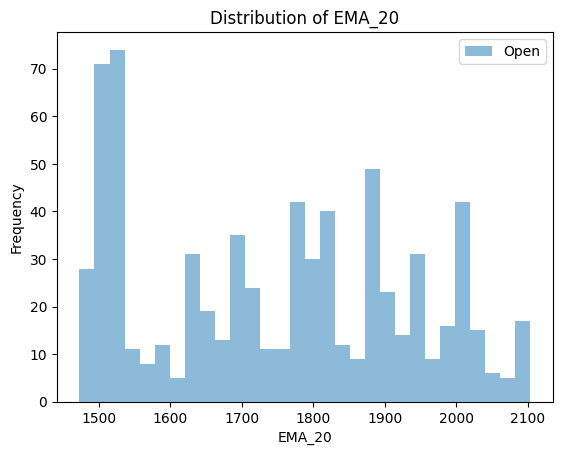

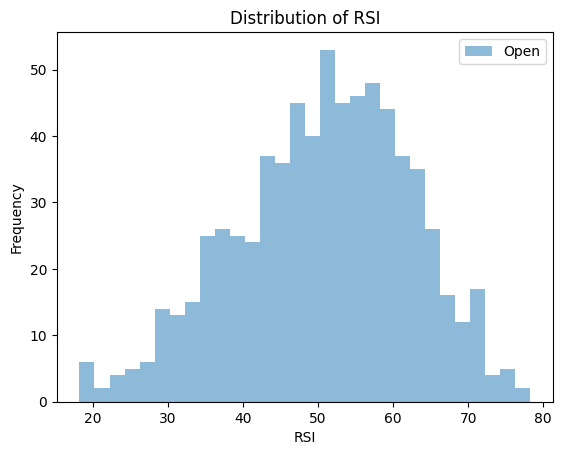

In [28]:
### lets call the loop through the features and call the function starting from the 3rd index

for feature in df.columns[2:]:
  create_histograms(feature)

In [29]:
## Lets normalize the data
### But first lets ensure the close price is at the index position
df.head()


,Date,Open,High,Low,Close,MA_10,MA_20,EMA_10,EMA_20,RSI
20,2025-01-01,1577.93,1579.28,1555.95,1563.99,1602.995,1613.6340,1596.387903,1602.934725,37.190541
21,2025-01-01,1563.90,1588.39,1562.16,1581.72,1594.842,1613.5370,1593.721012,1600.914275,43.785165
22,2025-01-01,1581.76,1590.90,1571.06,1578.87,1590.247,1613.2795,1591.020828,1598.814820,43.003555
23,2025-01-01,1578.75,1591.84,1559.58,1563.33,1586.008,1610.3095,1585.986132,1595.435314,38.923501
24,2025-01-01,1562.68,1572.41,1557.09,1558.78,1581.511,1607.7810,1581.039562,1591.944331,37.792881


In [30]:
df.drop('Date', axis=1, inplace=True)
df.head()

<ipython-input-30-9d69e33c694b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('Date', axis=1, inplace=True)


,Open,High,Low,Close,MA_10,MA_20,EMA_10,EMA_20,RSI
20,1577.93,1579.28,1555.95,1563.99,1602.995,1613.6340,1596.387903,1602.934725,37.190541
21,1563.90,1588.39,1562.16,1581.72,1594.842,1613.5370,1593.721012,1600.914275,43.785165
22,1581.76,1590.90,1571.06,1578.87,1590.247,1613.2795,1591.020828,1598.814820,43.003555
23,1578.75,1591.84,1559.58,1563.33,1586.008,1610.3095,1585.986132,1595.435314,38.923501
24,1562.68,1572.41,1557.09,1558.78,1581.511,1607.7810,1581.039562,1591.944331,37.792881


In [31]:
df = df[['Close', 'High', 'Low', 'MA_10', 'MA_20', 'EMA_10', 'EMA_20', 'RSI']]
df.head()

,Close,High,Low,MA_10,MA_20,EMA_10,EMA_20,RSI
20,1563.99,1579.28,1555.95,1602.995,1613.6340,1596.387903,1602.934725,37.190541
21,1581.72,1588.39,1562.16,1594.842,1613.5370,1593.721012,1600.914275,43.785165
22,1578.87,1590.90,1571.06,1590.247,1613.2795,1591.020828,1598.814820,43.003555
23,1563.33,1591.84,1559.58,1586.008,1610.3095,1585.986132,1595.435314,38.923501
24,1558.78,1572.41,1557.09,1581.511,1607.7810,1581.039562,1591.944331,37.792881


In [32]:
### Lets normalize the data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
print('Scaled data shape', df_scaled.shape)

Scaled data shape (713, 8)


In [33]:
### Lets create a time-series sequence an LSTM model can understand
def create_sequence(scaled_data, time_steps = 10):
  X,y =[], []
  for i in range(len(scaled_data)-time_steps):
    X.append(scaled_data[i:i+time_steps])
    y.append(scaled_data[i+time_steps,0])
  return np.array(X), np.array(y)

In [34]:
## Lets call the function
X,y = create_sequence(df_scaled)
X.shape,y.shape

((703, 10, 8), (703,))

In [35]:
# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [36]:
print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))
print("Number of features:", X_train.shape[2])


Training set size: 562
Testing set size: 141
Number of features: 8


In [37]:
X_train.shape, X_test.shape

((562, 10, 8), (141, 10, 8))

In [38]:
len(y_train), len(y_test)

(562, 141)

In [62]:
### Lets train our lstm model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),

    LSTM(units=50, return_sequences=True),
    Dropout(0.3),

    Dense(units=16),
    Dense(units=1)
])


### Lets compile the model
model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)


history_1 = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.1308 - val_loss: 0.2012
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0717 - val_loss: 0.1403
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0627 - val_loss: 0.1157
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0603 - val_loss: 0.1037
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0568 - val_loss: 0.1023
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0586 - val_loss: 0.1167
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0579 - val_loss: 0.1038
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0583 - val_loss: 0.1151
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0567 - val_loss: 0.1134
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0555 - val_loss: 0.1185
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0577 - val_loss: 0.1256
Epoch 12/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step

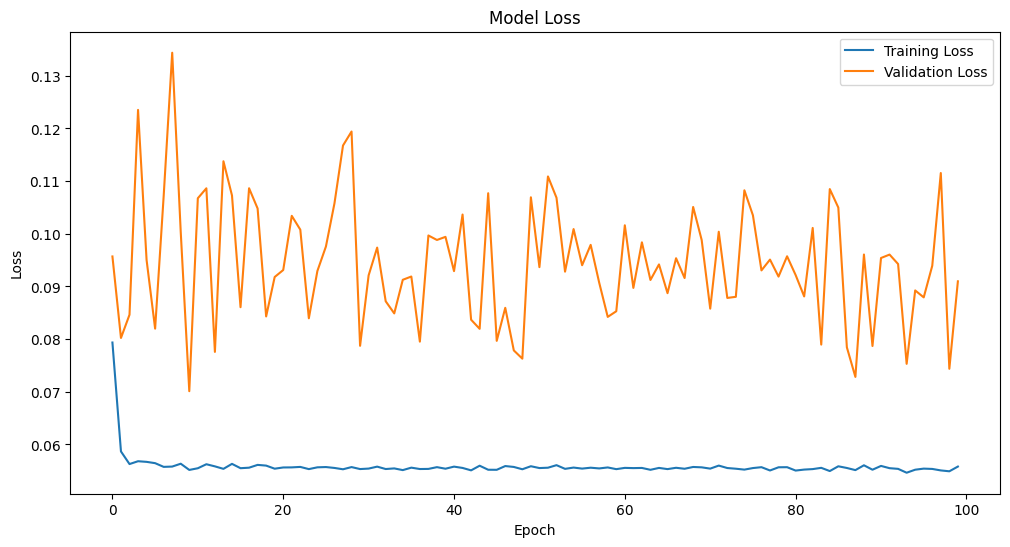

In [61]:
###  LETS EVALUATE THE Model
### lets visualize the performance

plt.figure(figsize=(12, 6))
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


In [41]:
## Lets evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
test_loss, train_loss

(0.10114239901304245, 0.04654867202043533)

In [42]:
### Lets predict the values of y
y_pred = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


In [43]:
### y_pred is suppose to be a 1D array but its a 3D array, so lets reshape to the length of y_pred

y_pred.shape

(141, 10, 1)

In [44]:
y_test.shape

(141,)

In [45]:
y_pred.shape, y_test.shape

((141, 10, 1), (141,))

In [46]:
y_pred_reshaped = y_pred.reshape(-1,1)
y_pred_reshaped.shape

(1410, 1)

In [47]:
num_features = df.shape[1]  # Get the original number of features (e.g., 8)

# Create an array of zeros with shape (1410, num_features - 1)
zeros_array = np.zeros((y_pred_reshaped.shape[0], num_features - 1))

# Stack `y_pred_reshaped` with `zeros_array` to match (1410, num_features)
y_pred_padded = np.hstack((y_pred_reshaped, zeros_array))  # Now shape: (1410, num_features)


In [48]:
### Lets inverse transform the y_pred_reshaped
y_pred_actual = scaler.inverse_transform(y_pred_padded)[:, 0]  # Extract only the first column


In [49]:
y_pred_actual.shape
y_pred_actual


array([1735.35787475, 1734.13258379, 1733.86963788, ..., 1711.96330351,
       1712.89910749, 1714.79171062])

In [50]:
y_test.shape

(141,)

In [51]:
y_test.shape
y_test

array([0.79944478, 0.78133929, 0.80954702, 0.82822127, 0.80563342,
       0.79577493, 0.77329542, 0.78740605, 0.80681156, 0.85744465,
       0.82247952, 0.81653463, 0.82258785, 0.80051459, 0.83844539,
       0.83617036, 0.81226894, 0.78509039, 0.76384319, 0.75364615,
       0.75884623, 0.78169138, 0.8063376 , 0.73883134, 0.77937572,
       0.76978807, 0.80315526, 0.81863362, 0.85638838, 0.88382423,
       0.88134606, 0.93350938, 0.90623603, 0.96047126, 0.94927212,
       0.92419257, 1.        , 0.99003318, 0.9454804 , 0.97353917,
       0.96305776, 0.97692464, 0.94733564, 0.97747986, 0.92974474,
       0.9090392 , 0.9189654 , 0.93406459, 0.89375042, 0.94281265,
       0.93444377, 0.88845555, 0.89293791, 0.83079423, 0.85818945,
       0.85565712, 0.81811903, 0.74752522, 0.71976437, 0.73291354,
       0.74794502, 0.76659219, 0.76833909, 0.79340511, 0.77176518,
       0.75173675, 0.79739996, 0.78601124, 0.8080845 , 0.81232311,
       0.77834654, 0.71226217, 0.7095538 , 0.66390412, 0.68834

In [52]:
### Lets inverse transform y_test
import numpy as np

# Ensure y_test has 2D shape
y_test_reshaped = y_test.reshape(-1, 1)  # Shape (141, 1)

# Create a zero array with the same number of features as the original dataset
zeros_array = np.zeros((y_test_reshaped.shape[0], df.shape[1] - 1))  # Shape (141, num_features-1)

# Stack y_test with zeros so it matches the scaler's expected shape
y_test_padded = np.hstack((y_test_reshaped, zeros_array))  # Shape (141, num_features)

# Apply inverse transform
y_test_actual = scaler.inverse_transform(y_test_padded)[:, 0]  # Extract only the first column

# Check shapes
print("Original y_test shape:", y_test.shape)          # (141, 1)
print("Padded y_test shape:", y_test_padded.shape)    # (141, num_features)
print("Inverse transformed y_test shape:", y_test_actual.shape)  # (141,)


Original y_test shape: (141,)
Padded y_test shape: (141, 8)
Inverse transformed y_test shape: (141,)


In [53]:
y_test_actual.shape
y_test_actual
y_test_actual.max()

2160.54

In [54]:
### Lets reshape y_pred_actual to (141,10)
y_pred_actual = y_pred_actual.reshape(-1,10)
y_pred_actual.shape
y_pred_actual.max()


1745.173759063482

In [55]:
### Lets use the mean to plot the line
mean_pred = y_pred_actual.mean(axis=1)
mean_pred.shape
len(mean_pred)

141

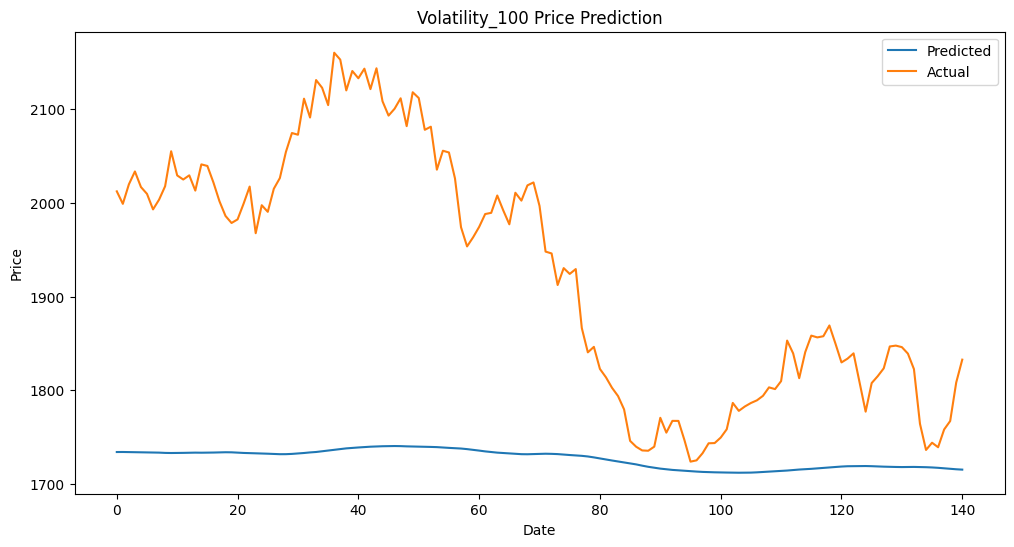

In [56]:
### lets plot the y_pred
plt.figure(figsize=(12, 6))
plt.plot(mean_pred, label='Predicted') # Lets use the mean of the 10 steps
plt.plot(y_test_actual, label='Actual')
plt.title('Volatility_100 Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [57]:
## Lets try to optimize the model

model_2 = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),

    LSTM(units=64, return_sequences=True),
    Dropout(0.3),
    LSTM(units=64, return_sequences=True),
    Dropout(0.3),

    Dense(units=16),
    Dense(units=1)
])


model_2.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

history_2 = model_2.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.1057 - val_loss: 0.1126
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0643 - val_loss: 0.1064
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0567 - val_loss: 0.1172
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0551 - val_loss: 0.1080
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0533 - val_loss: 0.1184
Epoch 6/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0583 - val_loss: 0.0887
Epoch 7/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0548 - val_loss: 0.0799
Epoch 8/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0566 - val_loss: 0.1163
Epoch 9/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0580 - val_loss: 0.1190
Epoch 10/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0534 - val_loss: 0.0846
Epoch 11/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0564 - val_loss: 0.0861
Epoch 12/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

In [58]:
history_2.history.keys()


dict_keys(['loss', 'val_loss'])

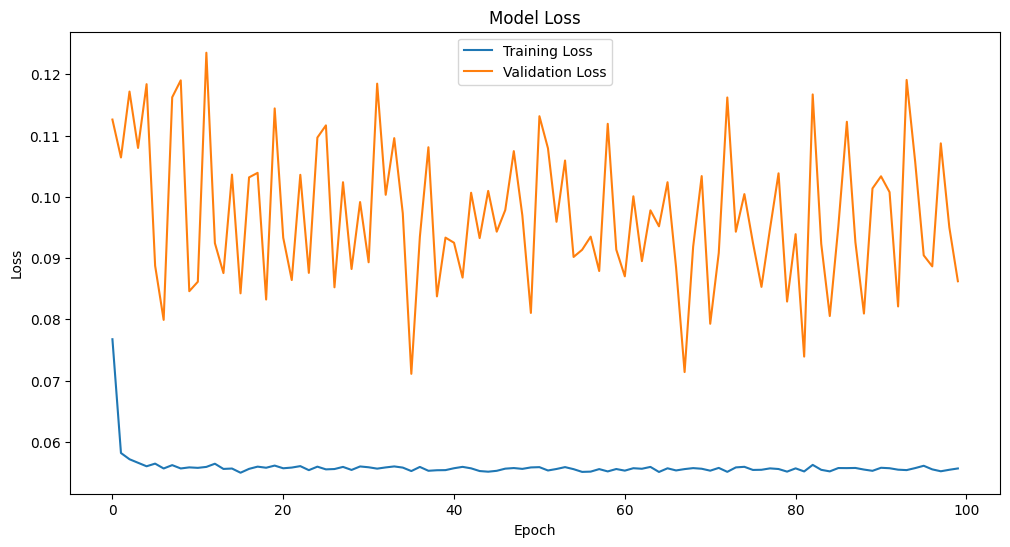

In [59]:
### Lets plot the loss and the val_loss
plt.figure(figsize=(12, 6))
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()